# Amazon Food Reviews - Classifier

In [6]:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# json_import = drive.CreateFile({'id':'1KpQKJnoX3XCpyW788srGxtO3nwZFJ4oE'})
# json_import.GetContentFile('database.sqlite')
# json_import = drive.CreateFile({'id':'1XRPgjWYDhIllbS4VWLGDIJ8-pcP7A_r4'})
# json_import.GetContentFile('final.sqlite')

In [89]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shubham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 


In [9]:
filtered_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [10]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
# def partition(x):
#     if x < 3:
#         return 'negative'
#     return 'positive'
def give_scores(score):
    score = np.asarray(score)
    score = np.where(score == 'positive', 1, 0)
    return score

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
# positiveNegative = actualScore.map(partition) 
positiveNegative = give_scores(actualScore)
filtered_data['Score'] = positiveNegative

In [11]:
filtered_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.


In [13]:
# find sentences containing HTML tags
# i=0;
# for sent in final['Text'].values:
#     if (len(re.findall('<.*?>', sent))):
# #         print(i)
# #         print(sent)
#         break
#     i += 1

stop = set(stopwords.words('english')) #set of stopwords
print(len(stop))
stop.remove('not')
print(len(stop))


179
178


In [14]:
stop = set(stopwords.words('english')) #set of stopwords
stop.remove('not')
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: #'positive': 
                        all_positive_words.append(s)    #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:  #'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [16]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [17]:

# store final table into an SQlLite table for future.
# conn = sqlite3.connect('final.sqlite')
# c=conn.cursor()
# conn.text_factory = str
# final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

## Converting AFR data into IMDB format

In [18]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

### As dataset is imbalanced, sampled equal datapoints for both the classes

In [19]:
# Sampling equal datapoints
final = shuffle(final)
final_balanced_reviews = final.loc[final['Score'] == 1][:57000]
neg_reviews = final.loc[final['Score'] == 0][:57000]
final_balanced_reviews = final_balanced_reviews.append(neg_reviews, ignore_index=True)
final_balanced_reviews = final_balanced_reviews[['Text', 'Score']]
final_balanced_reviews = shuffle(final_balanced_reviews)
final_balanced_reviews.head()

,Text,Score
113446,Received my package today and I was not please...,0
73475,"Used it to color on white chocolate candy, col...",0
92132,"The initial link states 12 - 20oz bottles, but...",0
46159,Imagine if you will a 1st grader in 1965.<br /...,1
31976,"Just what we wanted, loose rooibos tea. Green...",1


In [20]:
final_balanced_reviews['Score'].value_counts()

1    57000
0    57000
Name: Score, dtype: int64

## TF-IDF vectorization

In [66]:
X = final_balanced_reviews['Text']
Y = np.array(final_balanced_reviews['Score'])

In [119]:
X_train, X_test_df, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 123)
X_train_df, X_val_df, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 123)

In [120]:
print('train size ->', X_train_df.shape, Y_train.shape)
print('test size ->', X_test_df.shape, Y_test.shape)
print('validation size ->', X_val_df.shape, Y_val.shape)

train size -> (72960,) (72960,)
test size -> (22800,) (22800,)
validation size -> (18240,) (18240,)


### TF-IDF featurization after train test split to avoid Data leakage problem : 

`While vectorizing the data, apply the method fit_transform() on the train data and apply the method transform() on the CV/test data`

In [121]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_df)
X_val = vectorizer.transform(X_val_df)
X_test = vectorizer.transform(X_test_df)
# print(vectorizer.get_feature_names())

In [122]:
print(X_train.shape, X_val.shape, X_test.shape)

(72960, 53724) (18240, 53724) (22800, 53724)


### Logistic Regression Best Hyperparameter search using GridSearch

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


tuned_parameters = [{'C' : [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

# Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring='f1', cv=5)
model.fit(X_train, Y_train)

print('Best estimators ->', model.best_estimator_)
print('SCore ->', model.score(X_test, Y_test))


C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best estimators -> LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
SCore -> 0.8946318542488586


### Logistic Regression on AFR 

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

clf = LogisticRegression(random_state = 0, solver = 'liblinear').fit(X_train, Y_train)
y_val_predict = clf.predict(X_val)
y_test_predict = clf.predict(X_test)

print("----Scores------")
print("train score ->", clf.score(X_train, Y_train))
print("test score ->", clf.score(X_test, Y_test))
print("validation score ->", clf.score(X_val, Y_val))


filename = 'LR_model.sav'
joblib.dump(clf, filename)

----Scores------
train score -> 0.9151315789473684
test score -> 0.8957456140350877
validation score -> 0.8951206140350877


['LR_model.sav']

### Naive Bayes on AFR

In [86]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
alpha = [10 ** x for x in range(-5, 1)]


clf = MultinomialNB()
clf.fit(X_train, Y_train)
y_train_predict = clf.predict(X_train)
y_val_predict = clf.predict(X_val)
y_test_predict = clf.predict(X_test)

print("----Scores------")
print("train score ->", accuracy_score(Y_train, y_train_predict))
print("test score ->", accuracy_score(Y_test, y_test_predict))
print("validation score ->", accuracy_score(Y_val, y_val_predict))

----Scores------
train score -> 0.8976014254385964
test score -> 0.8742982456140351
validation score -> 0.8725877192982456


### SVM on AFR

for C = 1e-05
Log loss: 0.2599593863320821
for C = 0.0001
Log loss: 0.2735258764870851
for C = 0.001
Log loss: 0.3371305117757306
for C = 0.01
Log loss: 0.42025163666176973
for C = 0.1
Log loss: 0.42045323520561134
for C = 1
Log loss: 0.4204532351757916
for C = 10
Log loss: 0.42045323517184724
for C = 100
Log loss: 0.42045323528045125


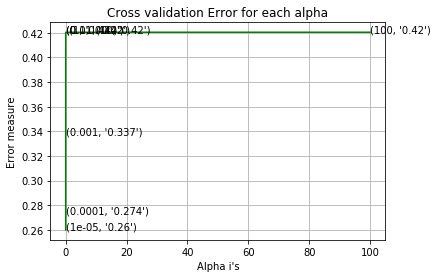

In [90]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_val)
    cv_log_error_array.append(log_loss(Y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log loss:", log_loss(Y_val, sig_clf_probs))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


## Training SVM with best hyperparameter

In [91]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, Y_train)

y_pred = sig_clf.predict_proba(X_train)
print("For best alpha :", alpha[best_alpha], "The train log-loss is", log_loss(Y_train, y_pred, labels=clf.classes_, eps=1e-15))
y_pred_cv = sig_clf.predict_proba(X_val)
print("For best alpha :", alpha[best_alpha], "The cross validation log-loss is", log_loss(Y_val, y_pred_cv, labels=clf.classes_, eps=1e-15))
y_pred_test = sig_clf.predict_proba(X_test)
print("for best alpha:", alpha[best_alpha], "The test log-loss is", log_loss(Y_test, y_pred_test, labels=clf.classes_, eps=1e-15))
y_train_pred = sig_clf.predict(X_train)
y_test_pred = sig_clf.predict(X_test)
y_val_pred = sig_clf.predict(X_val)
print("--"*20)
print("Train accuracy ->", accuracy_score(Y_train, y_train_pred))
print("Test accuracy ->", accuracy_score(Y_test, y_test_pred))
print("Validation accuracy ->", accuracy_score(Y_val, y_val_pred))

For best alpha : 1e-05 The train log-loss is 0.1966556410687968
For best alpha : 1e-05 The cross validation log-loss is 0.2599593863320821
for best alpha: 1e-05 The test log-loss is 0.255562568105566
----------------------------------------
Train accuracy -> 0.9358826754385965
Test accuracy -> 0.8957456140350877
Validation accuracy -> 0.8966008771929824


### Feature importance

In [153]:
def get_impfeature_names(indices, text, no_features):
    feat_len = len(vectorizer.get_feature_names())
#     print('feat len ->', feat_len)
    word_present = 0
    for i,v in enumerate(indices):
        if (v < feat_len):
            word = vectorizer.get_feature_names()[v]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))
    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [154]:
test_point_index = 1
predicted_class = sig_clf.predict(X_test[test_point_index])
print("Predicted class ->", predicted_class[0])
print("Predicted class probabilty ->", np.round(sig_clf.predict_proba(X_test[test_point_index]), 4))
print("Actual class ->", Y_test[test_point_index])

Predicted class -> 0
Predicted class probabilty -> [[0.9981 0.0019]]
Actual class -> 0


In [155]:
print(X_test_df.values[1])
print(vectorizer.get_feature_names()[22696])
print(len(clf.coef_[0]))

Scampi in Italian restaurants has a rich butter, garlic, and herb flavor. This product is very weak and watery in comparison. Even the noodles are limp and tasteless. Very disappointing.
great
53724


In [156]:
no_features = 500
indices = np.argsort(-clf.coef_)[:,:no_features]
get_impfeature_names(indices[0], X_test_df.values[test_point_index], no_features)

99 Text feature [rich] present in test data point [True]
174 Text feature [and] present in test data point [True]
Out of the top  500  features  2 are present in query point
